In [1]:
import ee
import geemap
import xarray as xr

In [2]:
!pip install xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00


In [3]:
import xee

In [4]:
ee.Authenticate()
# Change project to your own GEE project and allow third party access
ee.Initialize(project = 'newgeeproject2024', opt_url = 'https://earthengine-highvolume.googleapis.com')

In [5]:
map = geemap.Map(basemap = 'SATELLITE')

In [6]:
#call a shapefile  from GEE assets
roi_asset_id = 'projects/newgeeproject2024/assets/aoi_soc_NS'
roi = ee.FeatureCollection(roi_asset_id)
roi_geom = roi.geometry()
roi_geom

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.loadTable",
          "arguments": {
            "tableId": {
              "constantValue": "projects/newgeeproject2024/assets/aoi_soc_NS"
            }
          }
        }
      }
    }
  }
})

In [7]:
#plot the roi on top of the satellite base map
map.centerObject(roi_geom, 6)
map.addLayer(ee.Image().paint(roi_geom, 0, 2), {}, 'Study extent')
map

Map(center=[0.2526860235771413, 37.27220096663306], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
#use S2 data to calculate MSAVI for both periods
s2_p1 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate("2022-03-01","2023-02-28").filterBounds(roi_geom)
s2_p2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate("2023-03-01","2024-02-29").filterBounds(roi_geom)

In [9]:
#define a cloud mask
def mask_clouds_scl(image):
    scl = image.select('SCL')
    cloud_mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))  # exclude cloud, shadow, cirrus
    return image.updateMask(cloud_mask)

In [10]:
#define MSAVI, EVI and NDVI
def calc_indices(image):
    # Scale reflectance
    red = image.select('B4').multiply(0.0001)
    nir = image.select('B8').multiply(0.0001)
    blue = image.select('B2').multiply(0.0001)
    # MSAVI calculation
    msavi = nir.multiply(2).add(1).subtract(
        (nir.multiply(2).add(1).pow(2).subtract(nir.subtract(red).multiply(8))).sqrt()
    ).divide(2).rename('MSAVI')
    # NDVI calculation
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    # EVI calculation
    evi = nir.subtract(red).multiply(2.5).divide(
        nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)
    ).rename('EVI')
    # Add all indices as bands
    return image.addBands([msavi, ndvi, evi])

In [11]:
#Perform cloud mask and map MSAVI band
s2_vi_p1 = s2_p1.map(mask_clouds_scl).map(calc_indices)
s2_vi_p2 = s2_p2.map(mask_clouds_scl).map(calc_indices)

In [12]:
# Select only the indices bands (NDVI, EVI, MSAVI) to reduce data size
indices_p1 = s2_vi_p1.select(['NDVI', 'EVI', 'MSAVI'])
indices_p2 = s2_vi_p2.select(['NDVI', 'EVI', 'MSAVI'])

In [13]:
#define a smoothing function to reduce data gaps
def smooth_collection(collection, resample_days=14, window=4):
    # Define time range
    start_date = ee.Date(collection.first().get('system:time_start'))
    end_date = ee.Date(collection.sort('system:time_start', False).first().get('system:time_start'))
    # Create list of dates
    n_days = end_date.difference(start_date, 'day').round()
    date_list = ee.List.sequence(0, n_days, resample_days).map(lambda n: start_date.advance(ee.Number(n), 'day'))
    # Resample (median every 2 weeks)
    def resample_dates(d):
        d = ee.Date(d)
        d_end = d.advance(resample_days, 'day')
        subset = collection.filterDate(d, d_end)
        return subset.median().set('system:time_start', d.millis())
    resampled = ee.ImageCollection(date_list.map(resample_dates))
    # Rolling mean (smooth)
    def rolling_mean(img):
        time = ee.Date(img.get('system:time_start'))
        window_imgs = resampled.filterDate(
            time.advance(-resample_days * (window//2), 'day'),
            time.advance(resample_days * (window//2), 'day')
        )
        return window_imgs.mean().set('system:time_start', img.get('system:time_start'))

    smoothed = resampled.map(rolling_mean)
    return smoothed

In [14]:
# Smooth the indices for both periods
smooth_vi_p1 = smooth_collection(indices_p1)
smooth_vi_p2 = smooth_collection(indices_p2)

In [ ]:
smooth_vi_p1

In [ ]:
# Function to extract zonal mean for the selected vegetation indices
def zonal_mean(image, roi_geom):
    # Calculate zonal statistics (mean) within the region of interest (ROI)
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_geom,
        scale=100,
        maxPixels=1e8
    )

    # Return the statistics as an image property for further use
    return image.set(stats)

In [ ]:
# Apply zonal mean extraction for both periods
mean_vi_p1 = smooth_vi_p1.map(lambda img: zonal_mean(img, roi_geom)).getInfo()
mean_vi_p2 = smooth_vi_p2.map(lambda img: zonal_mean(img, roi_geom)).getInfo()

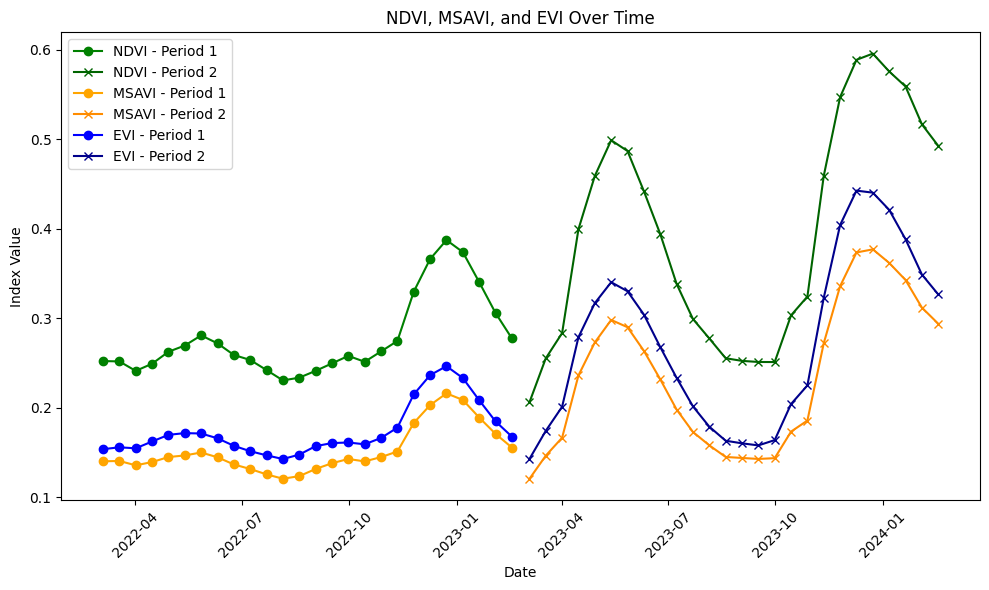

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the relevant data for NDVI, MSAVI, EVI, and time for period 1 and period 2
def extract_values(features):
    time_points = []
    ndvi_values = []
    msavi_values = []
    evi_values = []

    for feature in features:
        time_points.append(feature['properties']['system:time_start'])  # Time (milliseconds)
        ndvi_values.append(feature['properties']['NDVI'])
        msavi_values.append(feature['properties']['MSAVI'])
        evi_values.append(feature['properties']['EVI'])

    return time_points, ndvi_values, msavi_values, evi_values

# Extract data for both periods
time_p1, ndvi_p1, msavi_p1, evi_p1 = extract_values(mean_vi_p1['features'])
time_p2, ndvi_p2, msavi_p2, evi_p2 = extract_values(mean_vi_p2['features'])

# Convert time from milliseconds to datetime for better readability
import datetime
time_p1 = [datetime.datetime.fromtimestamp(t / 1000) for t in time_p1]
time_p2 = [datetime.datetime.fromtimestamp(t / 1000) for t in time_p2]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot NDVI
plt.plot(time_p1, ndvi_p1, label='NDVI - Period 1', color='green', marker='o')
plt.plot(time_p2, ndvi_p2, label='NDVI - Period 2', color='darkgreen', marker='x')

# Plot MSAVI
plt.plot(time_p1, msavi_p1, label='MSAVI - Period 1', color='orange', marker='o')
plt.plot(time_p2, msavi_p2, label='MSAVI - Period 2', color='darkorange', marker='x')

# Plot EVI
plt.plot(time_p1, evi_p1, label='EVI - Period 1', color='blue', marker='o')
plt.plot(time_p2, evi_p2, label='EVI - Period 2', color='darkblue', marker='x')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('NDVI, MSAVI, and EVI Over Time')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [15]:
#Load data into an array and just visualize monthly composites to see potential data gaps at 100m
ds_vi_p1 = xr.open_dataset(smooth_vi_p1 , engine='ee', crs='EPSG:4326', scale=0.001, geometry=roi_geom)
ds_vi_p2 = xr.open_dataset(smooth_vi_p2 , engine='ee', crs='EPSG:4326', scale=0.001, geometry=roi_geom)

In [ ]:
ds_vi_p1

<xarray.Dataset> Size: 76MB
Dimensions:  (time: 26, lon: 460, lat: 532)
Coordinates:
  * time     (time) datetime64[ns] 208B 2022-03-04T08:00:11.111000 ... 2023-0...
  * lon      (lon) float64 4kB 37.08 37.08 37.08 37.08 ... 37.53 37.53 37.54
  * lat      (lat) float64 4kB -0.00208 -0.00108 -8.03e-05 ... 0.5279 0.5289
Data variables:
    NDVI     (time, lon, lat) float32 25MB ...
    EVI      (time, lon, lat) float32 25MB ...
    MSAVI    (time, lon, lat) float32 25MB ...
Attributes:
    crs:      EPSG:4326

In [ ]:
#plot monthly composite period 1;
ds_vi_p1 = ds_vi_p1.sortby('time')
ds_vi_p1.EVI.plot(x='lon', y='lat', col='time', col_wrap=4, cmap='YlGn', robust=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#plot monthly composite period 2;
ds_vi_p2 = ds_vi_p2.sortby('time')
ds_vi_p2.EVI.plot(x='lon', y='lat', col='time', col_wrap=4, cmap='YlGn', robust=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.6 MB/s eta 0:00:00


In [ ]:
import netCDF4

In [ ]:
#save the 14 day composites for both periods: These commposites will be used to fit phenology
ds_vi_p1.to_netcdf('S2vi_14day_p1.nc')
ds_vi_p2.to_netcdf('S2vi_14day_p2.nc')

This is the end of the first code that extracts S2 collection from GEEm adds the VIs, smoothens and resamples to reduce data gaps, visualizes potential seasonality and then saves the composites for use in phenology metrics extraction